In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
# Загрузка данных из файлов в соответствующие переменные
train = pd.read_csv('data/train.csv', nrows=1000000)
questions = pd.read_csv('data/questions.csv')
lectures = pd.read_csv('data/lectures.csv')

In [65]:
# Вывод первых 5 строк ка каждой таблицы
display(train.head())
display(questions.head())
display(lectures.head())


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [66]:
# Выставлям типы данных в столбцах, которые будем использовать

questions['question_id'] = questions['question_id'].astype('int16')
questions['bundle_id'] = questions['bundle_id'].astype('int16')
questions['correct_answer'] = questions['correct_answer'].astype('int16')
questions['part'] = questions['part'].astype('int16')

lectures['lecture_id'] = lectures['lecture_id'].astype('int16')
lectures['tag'] = lectures['tag'].astype('int16')
lectures['part'] = lectures['part'].astype('int16')

train['row_id'] = train['row_id'].astype('int64')
train['user_id'] = train['user_id'].astype('int32')
train['content_id'] = train['content_id'].astype('int16')
train['content_type_id'] = train['content_type_id'].astype('int8')
train['task_container_id'] = train['task_container_id'].astype('int16')
train['user_answer'] = train['user_answer'].astype('int8')
train['answered_correctly'] = train['answered_correctly'].astype('int8')
train['prior_question_elapsed_time'] = train['prior_question_elapsed_time'].astype('float32')
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('bool')



In [67]:
# Проверка на наличие пропусков
print('Пропуски в данных train.csv\n')
print(train.isna().sum())
print('\nПропуски в данных questions.csv:\n')
print(questions.isna().sum())
print('\nПропуски в данных lectures.csv:\n')
print(lectures.isna().sum())

Пропуски в данных train.csv

row_id                                0
timestamp                             0
user_id                               0
content_id                            0
content_type_id                       0
task_container_id                     0
user_answer                           0
answered_correctly                    0
prior_question_elapsed_time       23723
prior_question_had_explanation        0
dtype: int64

Пропуски в данных questions.csv:

question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64

Пропуски в данных lectures.csv:

lecture_id    0
tag           0
part          0
type_of       0
dtype: int64


In [68]:
# Заполнение пропусков для prior_question_elapsed_time
train['prior_question_elapsed_time'] = train['prior_question_elapsed_time'].fillna(train['prior_question_elapsed_time'].median())

# Заполнение пропусков для prior_question_had_explanation
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].fillna(False).astype(bool)

# Фильтрация только для вопросов и объединение с questions для анализа метаданных вопросов
train_questions = train[train['content_type_id'] == 0].merge(
    questions, left_on='content_id', right_on='question_id', how='left'
)

In [ ]:
# Аналитика
# Процент правильно отвеченных вопросов
overall_correct_rate = train_questions['answered_correctly'].mean()
print(f'Правильно отвеченных вопросов: {overall_correct_rate * 100:.2f}%\n')

# Влияние времени на правильность ответа
time_correct_corr = train_questions[['prior_question_elapsed_time', 'answered_correctly']].corr().iloc[0, 1]
print(f'Корреляция между временем ответа и правильностью: {time_correct_corr:.2f}\n')

# Влияние объяснений на правильность ответа
explanation_effect = train_questions.groupby('prior_question_had_explanation')['answered_correctly'].mean()
print(f'Влияние объяснений на правильность ответа: {explanation_effect}')

# Анализ роли лекций: среднее количество просмотренных лекций на пользователя
lecture_count_per_user = train[train['content_type_id'] == 1].groupby('user_id').size().mean()
print(f'\nСреднее количество просмотренных лекций на пользователя: {lecture_count_per_user:.2f}')

# Частота ошибок по частям вопросов (анализ на основе question part)
error_rate_per_part = train_questions.groupby('part')['answered_correctly'].apply(lambda x: 1 - x.mean())
print(f'Частота ошибок по частям вопросов: {error_rate_per_part}')

Правильно отвеченных вопросов: 65.04%
Корреляция между временем ответа и правильностью: 0.00
Влияние объяснений на правильность ответа: prior_question_had_explanation
False    0.488795
True     0.665975
Name: answered_correctly, dtype: float64

Среднее количество просмотренных лекций на пользователя: 13.50
Частота ошибок по частям вопросов: part
1    0.264166
2    0.292742
3    0.307904
4    0.379041
5    0.393679
6    0.349305
7    0.354859
Name: answered_correctly, dtype: float64


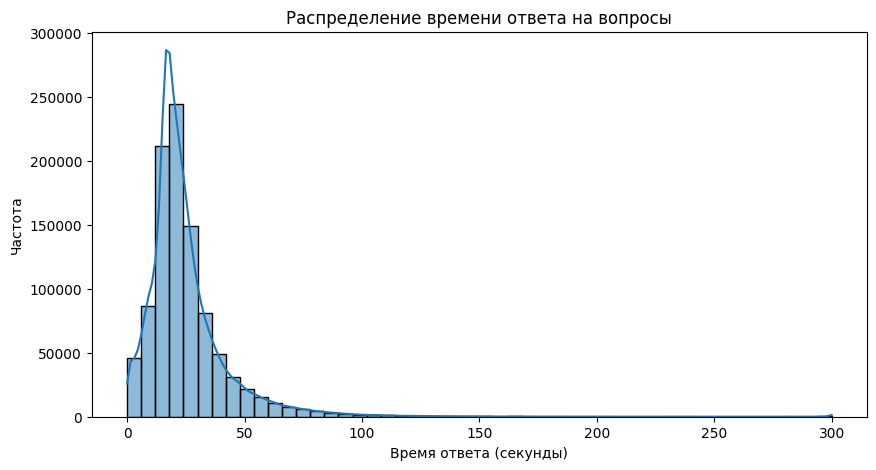

In [ ]:
# Распределение времени ответа на вопросы
plt.figure(figsize=(10, 5))
# Переводим время ответа в секунды
sns.histplot(train_questions['prior_question_elapsed_time'].dropna() / 1000, bins=50, kde=True)
plt.title('Распределение времени ответа на вопросы')
plt.xlabel('Время ответа (секунды)')
plt.ylabel('Частота')
plt.show()

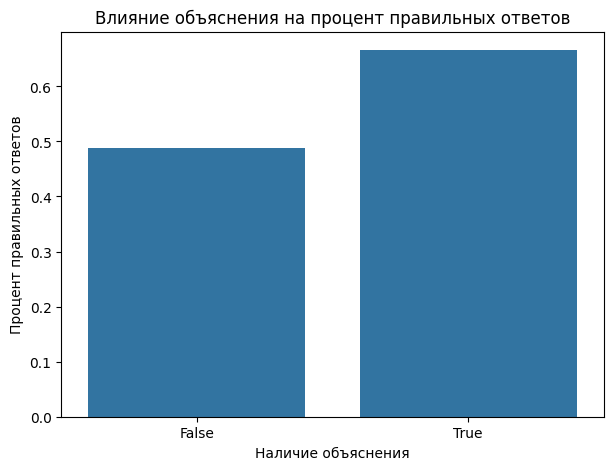

In [ ]:
# Корреляция наличия объяснения и правильности ответа
plt.figure(figsize=(7, 5))
sns.barplot(x=explanation_effect.index, y=explanation_effect.values)
plt.title("Влияние объяснения на процент правильных ответов")
plt.xlabel("Наличие объяснения")
plt.ylabel("Процент правильных ответов")
plt.show()

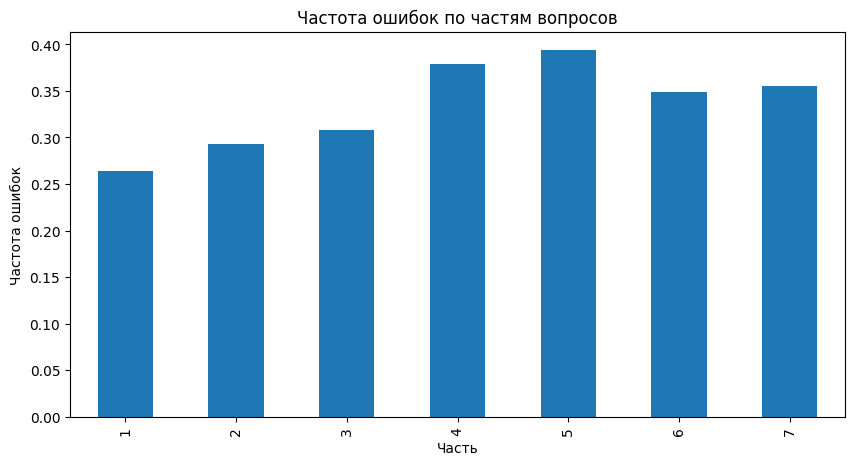

In [72]:
# Частота ошибок по частям вопросов
plt.figure(figsize=(10, 5))
error_rate_per_part.plot(kind='bar')
plt.title("Частота ошибок по частям вопросов")
plt.xlabel("Часть")
plt.ylabel("Частота ошибок")
plt.show()

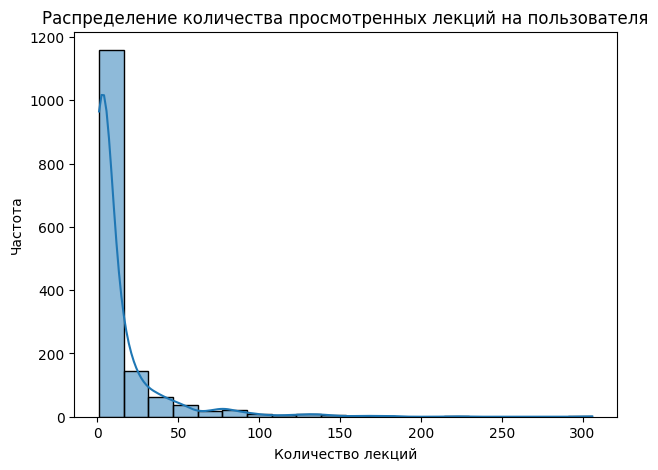

In [73]:
# Количество просмотренных лекций каждым пользователем (суммируем по user_id)
lecture_count_per_user = train[train['content_type_id'] == 1].groupby('user_id').size()

# Визуализация распределения количества просмотренных лекций
plt.figure(figsize=(7, 5))
sns.histplot(lecture_count_per_user, kde=True, bins=20)
plt.title("Распределение количества просмотренных лекций на пользователя")
plt.xlabel("Количество лекций")
plt.ylabel("Частота")
plt.show()